# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.utils import gen_batches
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.special import expit as sigmoid

# Модель

В качестве классификатора я реализовал логистическую регрессию, для этого я взял код из моей предыдущей работы и модифицировал его.

In [2]:
def batch_gradient_descent(model, X, y, lr, l1_coef, l2_coef, grad_clip_thr, update_lr, epochs, batch_size, eps=0.0001):
    # Функция обобщающая обычный, стохастический и mini batch градиентные спуски. Обобщаются они просто за счёт выбора параметров для класса Model 

    np.random.seed(42)
    def clip_grad(grad):
        if grad_clip_thr:
            np.clip(grad, -grad_clip_thr, grad_clip_thr, out=grad)

    n_features = len(model.coef_)
    n_samples = len(X)

    for _ in range(epochs):
        for batch_slice in shuffle(list(gen_batches(len(X), batch_size))):
            batch, true_y = shuffle(X[batch_slice], y[batch_slice])
            preds = model.predict_proba(batch)
            error = preds - true_y
        
            L2 = (2 / n_features * model.coef_).T
            L1 = np.sign(model.coef_).T
            grad = error.T @ batch / n_samples + l2_coef * L2 + l1_coef * L1
            
            clip_grad(grad)

            model.coef_ -= lr * grad.T
            if update_lr:
                lr = update_lr(lr)
            
            if np.max(abs(grad)) < eps:
                return

In [3]:
class Model:
    # Логистическая регрессия. В реализации я постарался сделать максимальную близость к estimator'ам из scikit, чтобы использовать некоторые функции оттуда 

    def __init__(self, method="gd", lr=1e-3, l1_coef=0, l2_coef=0, max_iters=100, update_lr=None, epochs=100, batch_size=10, grad_clip_thr=None, eps=0.0001):
        self.method = method
        self.lr = lr
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.max_iters = max_iters
        self.update_lr = update_lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.grad_clip_thr = grad_clip_thr
        self.eps = eps
        
    def predict(self, X):
        return sigmoid(X @ self.coef_) > 0.5

    def predict_proba(self, X):
        return sigmoid(X @ self.coef_)

    
    def fit(self, X, y):
        # Здесь меняются параметры batch_gradient_descent в зависимости от метода. Если это обычный gd, то батч равен всему датасету, а если это стохастический gd, то батч равен одному.
        # Это позволило не писать три разные функции с по-сути одинаковым кодом. 
        
        np.random.seed(42)
        n_features = X.shape[1]
        self.coef_ = np.random.normal(0, 1, (n_features, 1))


        match self.method:
            case "gd":
                batch_gradient_descent(self, X, y, lr=self.lr, l1_coef=self.l1_coef, l2_coef=self.l2_coef, grad_clip_thr=self.grad_clip_thr, update_lr=self.update_lr, epochs=self.max_iters, batch_size=len(X), eps=self.eps)
            case "bgd":
                batch_gradient_descent(self, X, y, lr=self.lr, l1_coef=self.l1_coef, l2_coef=self.l2_coef, grad_clip_thr=self.grad_clip_thr, update_lr=self.update_lr, epochs=self.epochs, batch_size=self.batch_size, eps=self.eps)
            case "sgd":
                batch_gradient_descent(self, X, y, lr=self.lr, l1_coef=self.l1_coef, l2_coef=self.l2_coef, grad_clip_thr=self.grad_clip_thr, update_lr=self.update_lr, epochs=self.epochs, batch_size=1, eps=self.eps)
            case _:
                raise Exception(f"No such method as {method} for .fit() in Model")

    def get_params(self, deep=True):
        return {"grad_clip_thr": self.grad_clip_thr, "method": self.method, "lr": self.lr, "l1_coef": self.l1_coef,
                "l2_coef": self.l2_coef, "max_iters": self.max_iters, "update_lr": self.update_lr,
                "epochs": self.epochs, "batch_size": self.batch_size, "eps": self.eps}  
    
    def set_params(self, **parameters):
        for key, value in parameters.items():
            self.__dict__[key] = value
        return self

    def score(self, X, y):
        # accuracy
        preds = self.predict_proba(X) > 0.5
        return accuracy_score(y, preds)



# Датасет

Возьмём данные заболеваний сердца у пациентов, которые можно скачать [тут](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data).

Описание датасета: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 1 = normal; 2 = fixed defect; 3 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

In [4]:
df = pd.read_csv("heart.csv")

In [5]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.target.value_counts()

target
1    526
0    499
Name: count, dtype: int64

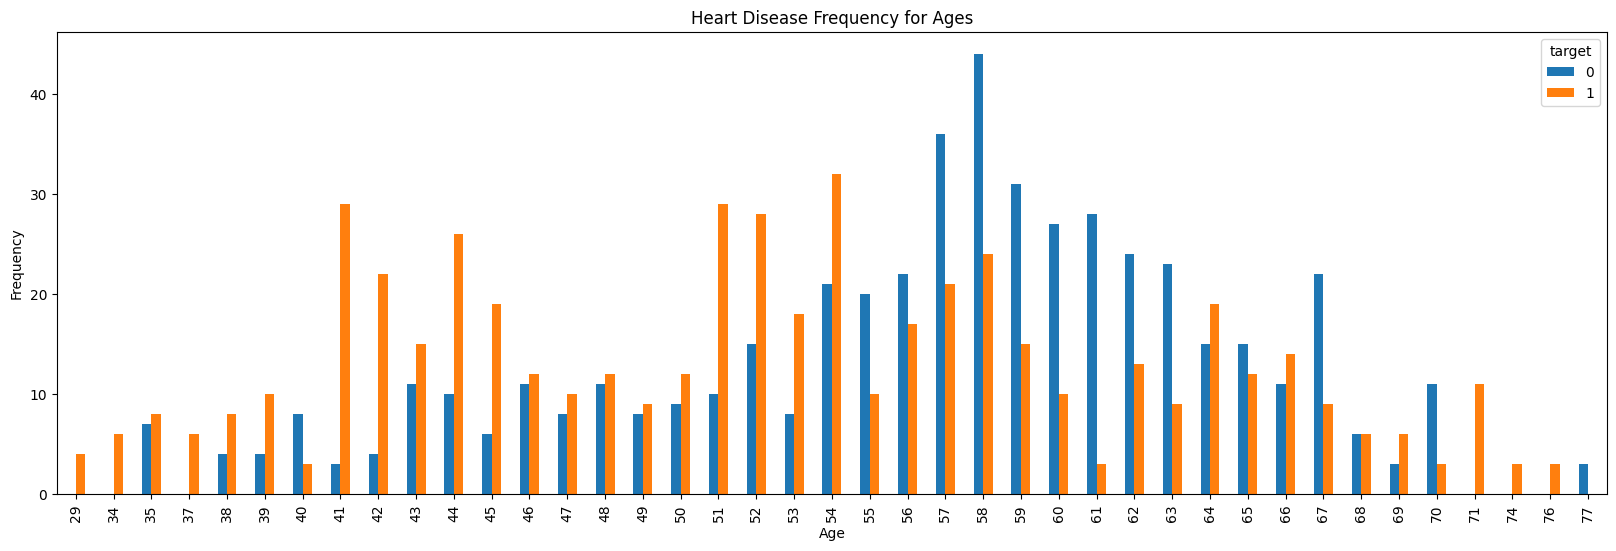

In [7]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

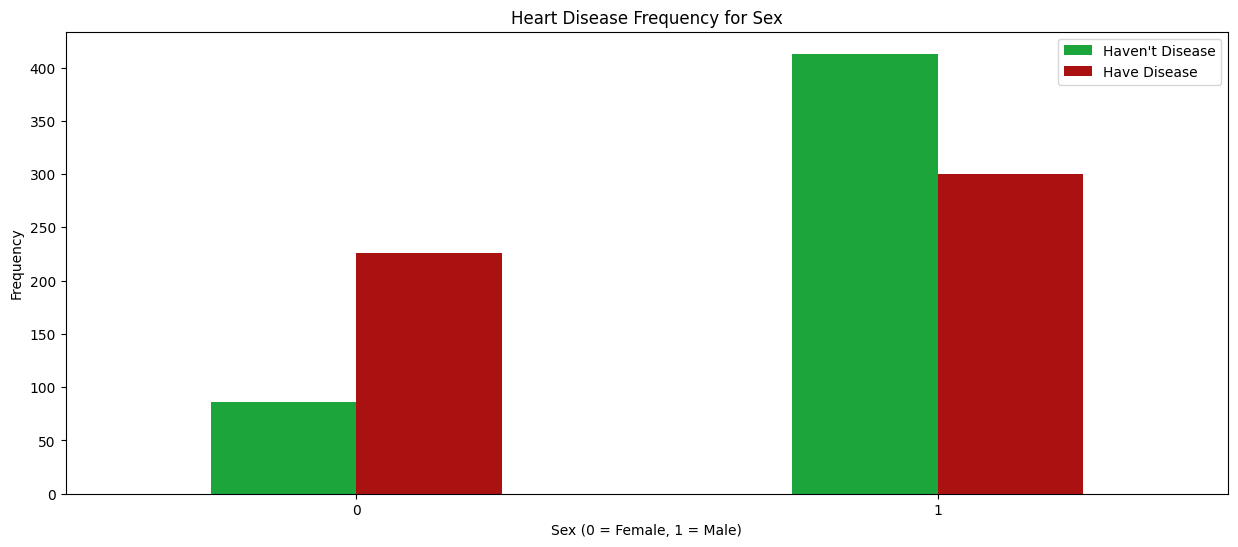

In [8]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

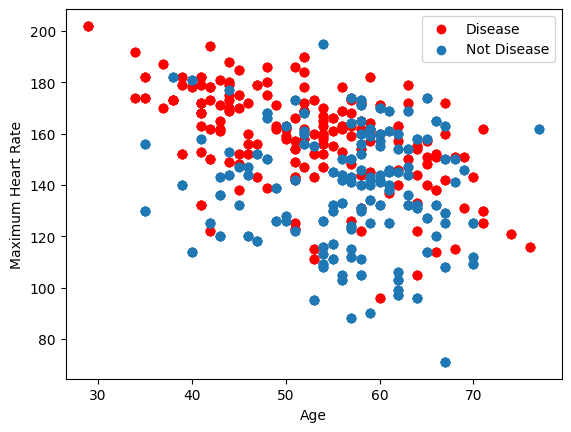

In [9]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

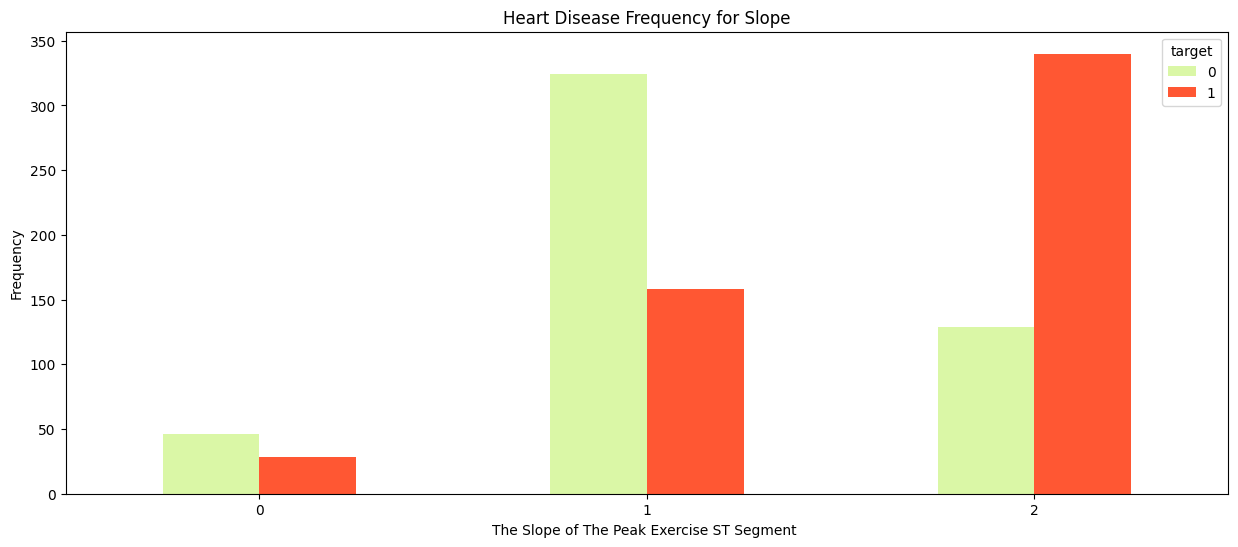

In [10]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()

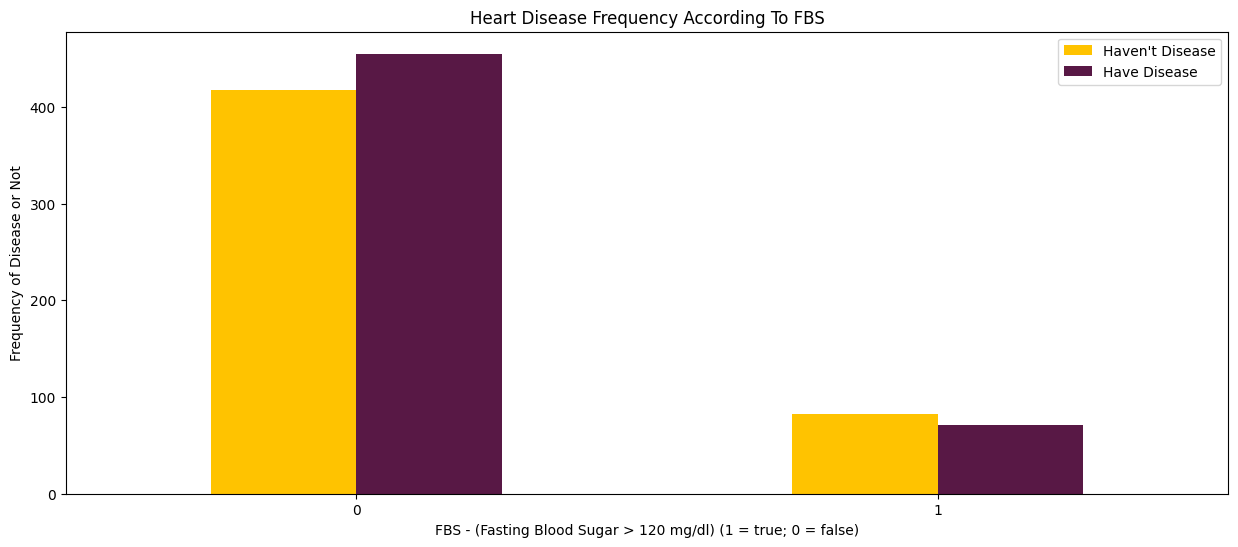

In [11]:
pd.crosstab(df.fbs,df.target).plot(kind="bar", figsize=(15, 6), color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

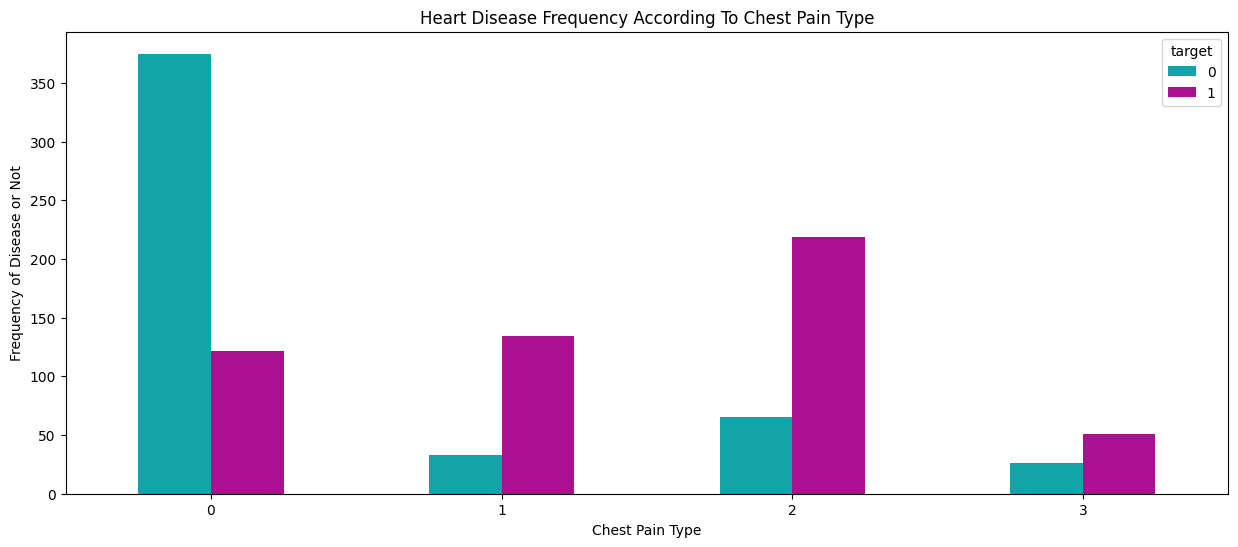

In [12]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

### Преобразование категориальных признаков
Закодируем категориальные признаки **cp**, **thal** и **slope**.

In [13]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp", dtype=float)
thal_dum = pd.get_dummies(df['thal'], prefix = "thal", dtype=float)
slope_dum = pd.get_dummies(df['slope'], prefix = "slope", dtype=float)

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,53,1,140,203,1,0,155,1,3.1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,70,1,145,174,0,1,125,1,2.6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,61,1,148,203,0,1,161,0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,62,0,138,294,1,1,106,0,1.9,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


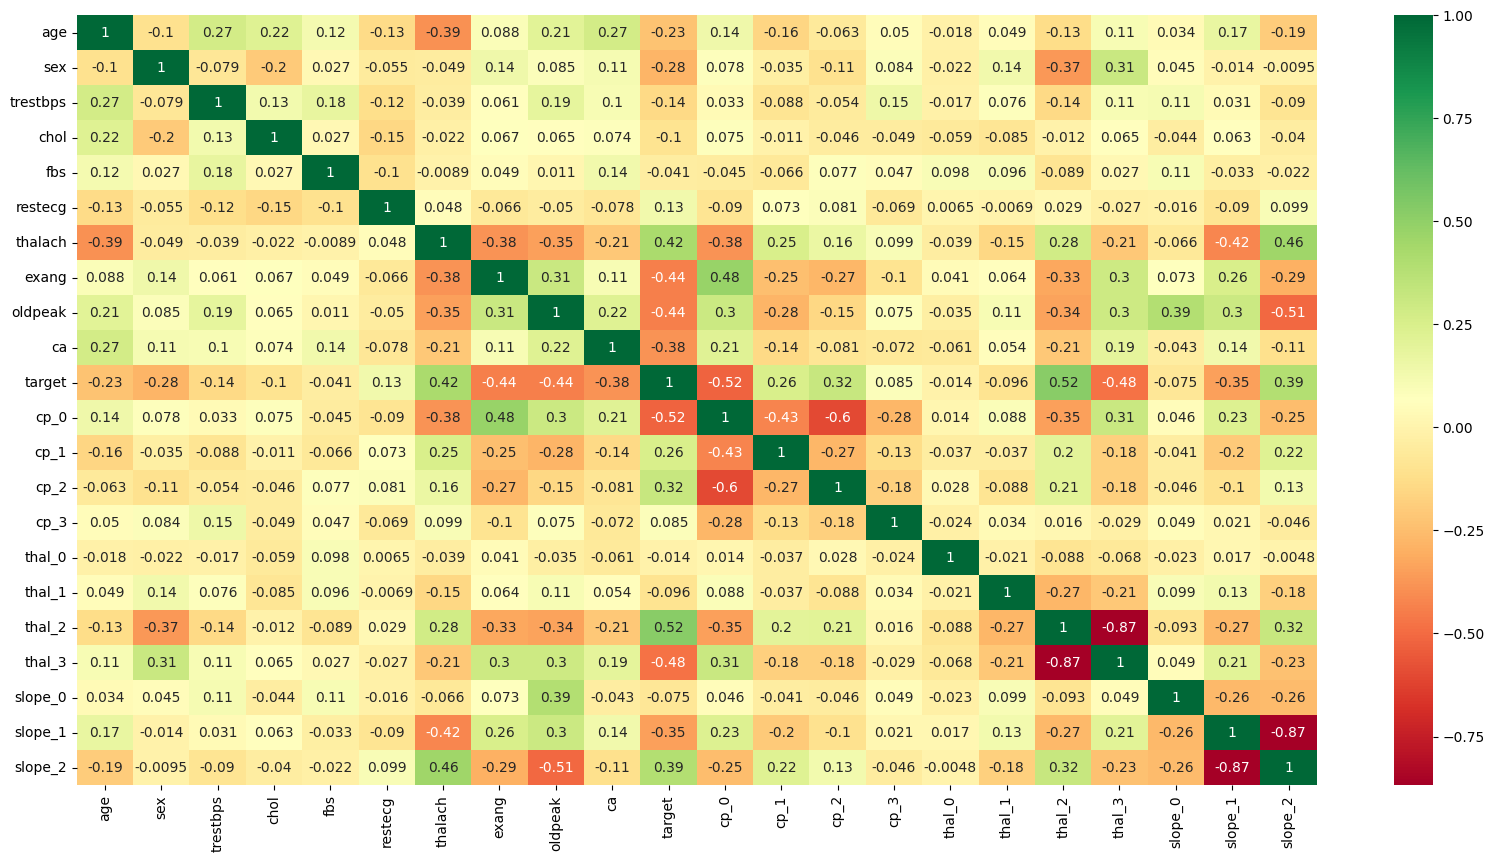

In [14]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Заметим, что у некоторых из признаков, которые мы добавили, есть сильная корреляция. Исключим часть признаков.

In [15]:
df = df.drop(["slope_1", "thal_3", "cp_2"], axis=1)

# Подготовка данных для обучения

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df["bias"] = np.ones(len(df))
df.head()

y = df['target'].to_numpy()
X = df.drop(columns=['target'])

y = np.expand_dims(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Подбор гиперпараметров

In [17]:
l2_coef_grid = np.linspace(0, 1, 6)
lr_grid = np.logspace(0, -3, 4)

my_log_reg = Model(
    lr=0.1,
    l2_coef=0.2,
    epochs=4000,
    grad_clip_thr=10,
    method="bgd",
    batch_size=200,
    update_lr=lambda x: x * 0.999,
    eps=0.0001
)

searcher = GridSearchCV(
    my_log_reg,
    {
        "l2_coef": l2_coef_grid,
        "lr": lr_grid,
    },
    cv=5,
    n_jobs=15,
    pre_dispatch=15,
    scoring="accuracy",
    refit=True,
)
searcher.fit(X_train_scaled, y_train)
print(searcher.best_params_)
my_log_reg = searcher.best_estimator_
my_log_reg.score(X_test_scaled, y_test)

{'l2_coef': 0.0, 'lr': 0.1}


0.8181818181818182

In [18]:
from sklearn.linear_model import LogisticRegression

C_grid = np.linspace(1e-3, 2, 7)
solver_grid = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]

log_reg = LogisticRegression(max_iter=2000, tol=1e-5, random_state=42)
searcher = GridSearchCV(
    log_reg,
    {"solver": solver_grid, "C": C_grid},
    cv=5,
    n_jobs=15,
    pre_dispatch=15,
    scoring="accuracy",
    refit=True,
)

searcher.fit(X_train_scaled, y_train.squeeze())
print(searcher.best_params_)
log_reg = searcher.best_estimator_
log_reg.score(X_test_scaled, y_test)

{'C': 0.33416666666666667, 'solver': 'lbfgs'}


0.8084415584415584

In [19]:
from sklearn.svm import SVC

C_grid = np.linspace(1e-3, 3, 10)
kernel_grid = ["linear", "poly", "rbf", "sigmoid"]
degree_grid = [2, 3, 4, 5, 6]

svm = SVC(tol=1e-5, random_state=42)
searcher = GridSearchCV(
    svm,
    {"kernel": kernel_grid, "C": C_grid, "degree": degree_grid},
    cv=5,
    n_jobs=15,
    pre_dispatch=15,
    scoring="accuracy",
    refit=True,
)

searcher.fit(X_train_scaled, y_train.squeeze())
print(searcher.best_params_)
svm = searcher.best_estimator_
svm.score(X_test_scaled, y_test)

{'C': 2.666777777777778, 'degree': 4, 'kernel': 'poly'}


0.9318181818181818

In [20]:
from sklearn.neighbors import KNeighborsClassifier

algorithm_grid = ["ball_tree", "kd_tree", "brute"]
n_neighbors_grid = [1, 3, 5, 7, 9]
weights_grid = ["uniform", "distance"]

knn = KNeighborsClassifier()
searcher = GridSearchCV(
    knn,
    {"n_neighbors": n_neighbors_grid, "algorithm": algorithm_grid, "weights": weights_grid},
    cv=5,
    n_jobs=15,
    pre_dispatch=15,
    scoring="accuracy",
    refit=True,
)

searcher.fit(X_train_scaled, y_train.squeeze())
print(searcher.best_params_)
knn = searcher.best_estimator_
knn.score(X_test_scaled, y_test)

{'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}


0.9902597402597403

In [21]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_grid = np.logspace(1, -9, 11)

nb = GaussianNB()
searcher = GridSearchCV(
    nb,
    {"var_smoothing": var_smoothing_grid},
    cv=5,
    n_jobs=15,
    pre_dispatch=15,
    scoring="accuracy",
    refit=True,
)

searcher.fit(X_train_scaled, y_train.squeeze())
print(searcher.best_params_)
nb = searcher.best_estimator_
nb.score(X_test_scaled, y_test)

{'var_smoothing': 0.1}


0.7954545454545454

In [22]:
from sklearn.tree import DecisionTreeClassifier

criterion_grid = ["gini", "entropy", "log_loss"]
max_features_grid = [None, "sqrt", "log2", 0.5]
random_state_grid = [42, 509, 1337]
min_samples_split_grid = [2, 3, 4, 5]

dtc = DecisionTreeClassifier()
searcher = GridSearchCV(
    dtc,
    {
        "criterion": criterion_grid,
        "max_features": max_features_grid,
        "random_state": random_state_grid,
        "min_samples_split": min_samples_split_grid,
    },
    cv=5,
    n_jobs=15,
    pre_dispatch=15,
    scoring="accuracy",
    refit=True,
)

searcher.fit(X_train_scaled, y_train.squeeze())
print(searcher.best_params_)
dtc = searcher.best_estimator_
dtc.score(X_test_scaled, y_test)

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 1337}


0.9805194805194806

# Сравнение моделей

In [24]:
y_my_lr = my_log_reg.predict(X_test_scaled)
y_lr = log_reg.predict(X_test_scaled)
y_knn = knn.predict(X_test_scaled)
y_svm = svm.predict(X_test_scaled)
y_nb = nb.predict(X_test_scaled)
y_dtc = dtc.predict(X_test_scaled)

In [25]:
from sklearn.metrics import confusion_matrix

cm_my_lr = confusion_matrix(y_test, y_my_lr)
cm_lr = confusion_matrix(y_test, y_lr)
cm_knn = confusion_matrix(y_test, y_knn)
cm_svm = confusion_matrix(y_test, y_svm)
cm_nb = confusion_matrix(y_test, y_nb)
cm_dtc = confusion_matrix(y_test, y_dtc)

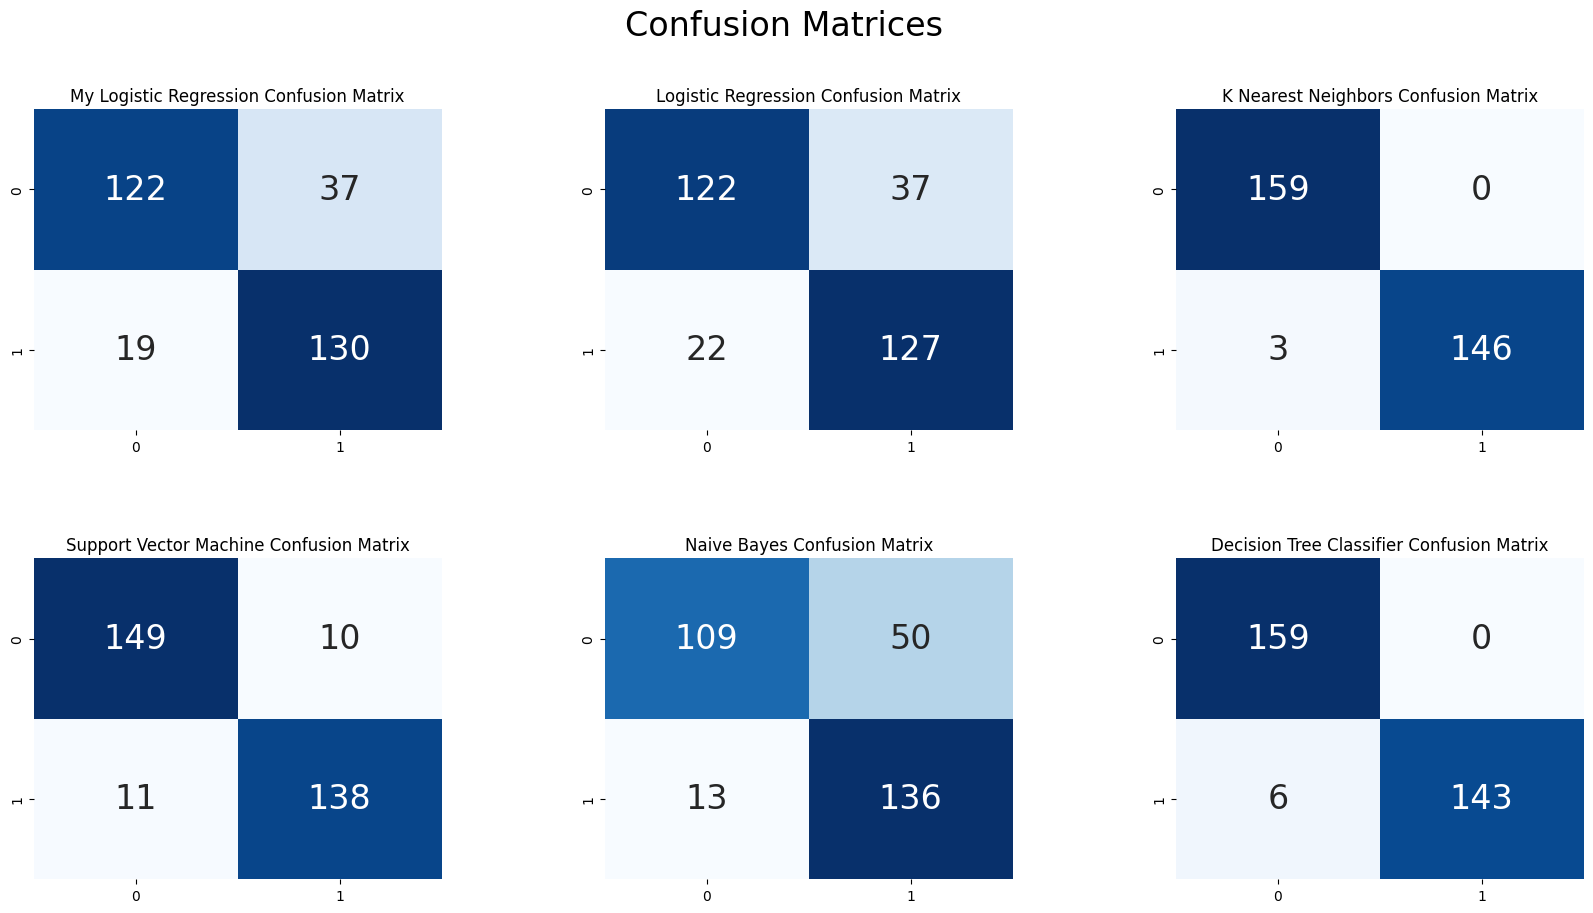

In [26]:
plt.figure(figsize=(20, 10))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)
plt.subplot(2,3,1)

plt.title("My Logistic Regression Confusion Matrix")
sns.heatmap(cm_my_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Полученная мною реализация логистической регрессии оказалась немного лучше реализации из scikit. Лучшей моделью для этих данных оказалась knn 